In [1]:
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [2]:
!unzip data.zip


Archive:  data.zip
   creating: data/host/
  inflating: data/host/000002.png    
  inflating: data/host/000003 (3).png  
  inflating: data/host/000003 (4).png  
  inflating: data/host/000009 (3).png  
  inflating: data/host/000009 (4).png  
  inflating: data/host/000010.png    
  inflating: data/host/000015.png    
  inflating: data/host/000016 (3).png  
  inflating: data/host/000016 (4).png  
  inflating: data/host/000017.png    
  inflating: data/host/000018 (2).png  
  inflating: data/host/000019 (3).png  
  inflating: data/host/000019 (4).png  
  inflating: data/host/000020 (3).png  
  inflating: data/host/000020 (4).png  
  inflating: data/host/000021.png    
  inflating: data/host/000023 (2).png  
  inflating: data/host/000024 (2).png  
  inflating: data/host/000026 (2).png  
  inflating: data/host/000026.png    
  inflating: data/host/000027 (2).png  
  inflating: data/host/000027.png    
  inflating: data/host/000029 (5).png  
  inflating: data/host/000029 (9).png  
  inflating

In [3]:
import cv2
import numpy as np
import pywt
import torch
import torch.nn as nn
import os


In [4]:
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32) / 255.0


In [5]:
def embed_watermark(host, watermark, alpha):
    coeffs = pywt.dwt2(host, 'haar')
    LL, (LH, HL, HH) = coeffs

    wm = cv2.resize(watermark, LH.shape[::-1])

    LH_emb = LH + alpha * wm
    HL_emb = HL + alpha * wm

    return pywt.idwt2((LL, (LH_emb, HL_emb, HH)), 'haar')


In [6]:
def extract_watermark(wm_img, host, alpha):
    c1 = pywt.dwt2(host, 'haar')
    c2 = pywt.dwt2(wm_img, 'haar')

    LH1, HL1 = c1[1][0], c1[1][1]
    LH2, HL2 = c2[1][0], c2[1][1]

    wm = ((LH2 - LH1) + (HL2 - HL1)) / (2 * alpha)
    return np.clip(wm, 0, 1)


In [7]:
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018


In [9]:
model = AlphaNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

HOST_DIR = "data/host"
WM_DIR = "data/watermark"

for epoch in range(100):
    total_loss = 0

    for h in os.listdir(HOST_DIR):
        host = load_gray(os.path.join(HOST_DIR, h))
        wm = load_gray(os.path.join(WM_DIR, np.random.choice(os.listdir(WM_DIR))), size=256)

        host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).cuda()

        alpha = model(host_t).item()

        wm_img = embed_watermark(host, wm, alpha)
        wm_ext = extract_watermark(wm_img, host, alpha)

        loss = np.mean((wm_ext - wm) ** 2)
        total_loss += loss

        optimizer.zero_grad()
        torch.tensor(loss, requires_grad=True).backward()
        optimizer.step()

    print(f"Epoch {epoch}: Loss = {total_loss:.6f}")


Epoch 0: Loss = 0.000000
Epoch 1: Loss = 0.000000
Epoch 2: Loss = 0.000000
Epoch 3: Loss = 0.000000
Epoch 4: Loss = 0.000000
Epoch 5: Loss = 0.000000
Epoch 6: Loss = 0.000000
Epoch 7: Loss = 0.000000
Epoch 8: Loss = 0.000000
Epoch 9: Loss = 0.000000
Epoch 10: Loss = 0.000000
Epoch 11: Loss = 0.000000
Epoch 12: Loss = 0.000000
Epoch 13: Loss = 0.000000
Epoch 14: Loss = 0.000000
Epoch 15: Loss = 0.000000
Epoch 16: Loss = 0.000000
Epoch 17: Loss = 0.000000
Epoch 18: Loss = 0.000000
Epoch 19: Loss = 0.000000
Epoch 20: Loss = 0.000000
Epoch 21: Loss = 0.000000
Epoch 22: Loss = 0.000000
Epoch 23: Loss = 0.000000
Epoch 24: Loss = 0.000000
Epoch 25: Loss = 0.000000
Epoch 26: Loss = 0.000000
Epoch 27: Loss = 0.000000
Epoch 28: Loss = 0.000000
Epoch 29: Loss = 0.000000
Epoch 30: Loss = 0.000000
Epoch 31: Loss = 0.000000
Epoch 32: Loss = 0.000000
Epoch 33: Loss = 0.000000
Epoch 34: Loss = 0.000000
Epoch 35: Loss = 0.000000
Epoch 36: Loss = 0.000000
Epoch 37: Loss = 0.000000
Epoch 38: Loss = 0.000

In [10]:
MODEL_PATH = "/content/alpha_net.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at", MODEL_PATH)


Model saved at /content/alpha_net.pth


In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
import cv2
import numpy as np
import os
import torch

TEST_HOST = "/content/data/host"
TEST_WM = "/content/data/watermark"
OUT_DIR = "/content/results"
os.makedirs(OUT_DIR, exist_ok=True)

for hname in os.listdir(TEST_HOST):
    host = load_gray(os.path.join(TEST_HOST, hname), size=256)
    wm = load_gray(os.path.join(TEST_WM, np.random.choice(os.listdir(TEST_WM))), size=64)

    # Predict adaptive alpha
    host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).float().to(device)
    with torch.no_grad():
        alpha = model(host_t)[0, 0].cpu().numpy()

    # Embed watermark
    watermarked = embed_watermark(host, wm, alpha)

    # Extract watermark
    extracted = extract_watermark(watermarked, host, alpha)

    # Metrics
    p = psnr(host, watermarked, data_range=1.0)
    s = ssim(host, watermarked, data_range=1.0)

    print(f"{hname} → PSNR: {p:.2f}, SSIM: {s:.4f}")

    # Save images
    cv2.imwrite(f"{OUT_DIR}/host_{hname}", (host*255).astype(np.uint8))
    cv2.imwrite(f"{OUT_DIR}/wm_{hname}", (watermarked*255).astype(np.uint8))
    cv2.imwrite(f"{OUT_DIR}/ext_{hname}", (extracted*255).astype(np.uint8))


000054 (6).png → PSNR: 43.03, SSIM: 0.9634
Te-no_0111.jpg → PSNR: 42.60, SSIM: 0.9512
Te-gl_0023.jpg → PSNR: 42.98, SSIM: 0.9590
000078 (6).png → PSNR: 42.59, SSIM: 0.9742
000091 (3).png → PSNR: 43.03, SSIM: 0.9763
000155 (3).png → PSNR: 42.59, SSIM: 0.9610
000139 (5).png → PSNR: 43.03, SSIM: 0.9690
Tr-me_0092.jpg → PSNR: 42.60, SSIM: 0.9613
000033 (9).png → PSNR: 42.59, SSIM: 0.9702
000115 (2).png → PSNR: 43.03, SSIM: 0.9676
000163 (3).png → PSNR: 42.59, SSIM: 0.9677
000147.png → PSNR: 42.98, SSIM: 0.9665
Tr-me_0144.jpg → PSNR: 43.03, SSIM: 0.9662
Te-gl_0035.jpg → PSNR: 43.04, SSIM: 0.9558
7 - Copy - Copy.png → PSNR: 42.60, SSIM: 0.9908
Te-gl_0049.jpg → PSNR: 42.60, SSIM: 0.9557
000129 (5).png → PSNR: 42.59, SSIM: 0.9690
000105.png → PSNR: 42.97, SSIM: 0.9742
Te-no_0054.jpg → PSNR: 43.03, SSIM: 0.9656
000010.png → PSNR: 42.59, SSIM: 0.9756
000122.png → PSNR: 42.59, SSIM: 0.9698
000066 (9).png → PSNR: 42.59, SSIM: 0.9690
Tr-pi_0047.jpg → PSNR: 43.03, SSIM: 0.9753
Tr-pi_0039.jpg → PSNR:

In [14]:
import torch
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlphaNet().to(device)
model.load_state_dict(torch.load("/content/alpha_net.pth", map_location=device))
model.eval()

print("✅ Model loaded")


✅ Model loaded


In [15]:
from google.colab import files

print("Upload HOST image")
host_file = files.upload()

print("Upload WATERMARK image")
wm_file = files.upload()

host_path = list(host_file.keys())[0]
wm_path = list(wm_file.keys())[0]


Upload HOST image


Saving 7 - Copy (3).png to 7 - Copy (3).png
Upload WATERMARK image


Saving watermark.png to watermark.png


Predicted alpha: 0.010783472


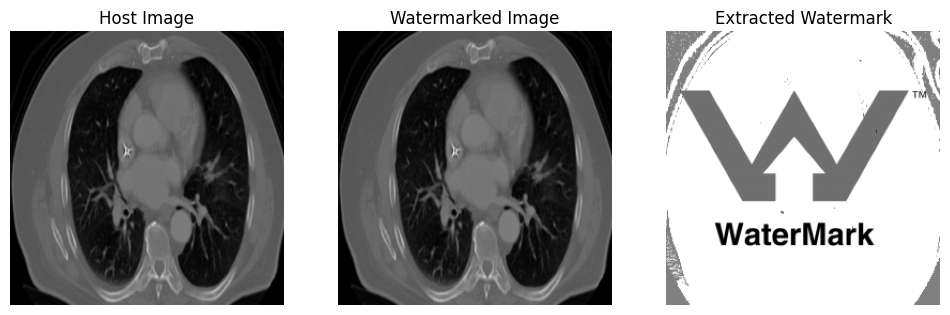

In [16]:
# ===============================
# Watermarking Inference Code
# ===============================

import cv2
import numpy as np
import pywt
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

# -------------------------------
# Load AlphaNet model
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # adaptive alpha between 0.002 and 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlphaNet().to(device)
model.load_state_dict(torch.load("/content/alpha_net.pth", map_location=device))
model.eval()

# -------------------------------
# Utility functions
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32) / 255.0

def embed_watermark(host, watermark, alpha):
    coeffs = pywt.dwt2(host, 'haar')
    LL, (LH, HL, HH) = coeffs

    wm = cv2.resize(watermark, LH.shape[::-1])
    LH_emb = LH + alpha * wm
    HL_emb = HL + alpha * wm

    wm_img = pywt.idwt2((LL, (LH_emb, HL_emb, HH)), 'haar')
    return np.clip(wm_img, 0, 1)

def extract_watermark(wm_img, host, alpha):
    c1 = pywt.dwt2(host, 'haar')
    c2 = pywt.dwt2(wm_img, 'haar')

    LH1, HL1 = c1[1][0], c1[1][1]
    LH2, HL2 = c2[1][0], c2[1][1]

    wm = ((LH2 - LH1) + (HL2 - HL1)) / (2 * alpha)
    return np.clip(wm, 0, 1)

# -------------------------------
# User Input: host image & watermark
# -------------------------------
host_path = "/content/data/host/000016 (3).png"        # change to your host image path
wm_path = "/content/data/watermark/watermark.png"  # change to your watermark image path

host = load_gray(host_path)
wm = load_gray(wm_path, size=host.shape[0])

# -------------------------------
# Predict adaptive alpha
# -------------------------------
host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    alpha = model(host_t)[0,0].cpu().numpy()
print("Predicted alpha:", alpha)

# -------------------------------
# Embed watermark
# -------------------------------
wm_img = embed_watermark(host, wm, alpha)

# -------------------------------
# Extract watermark
# -------------------------------
wm_ext = extract_watermark(wm_img, host, alpha)

# -------------------------------
# Display results
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Host Image")
plt.imshow(host, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(wm_img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(wm_ext, cmap='gray')
plt.axis('off')

plt.show()


Predicted alpha: 0.010783472
PSNR (Host vs Watermarked): 43.15
SSIM (Host vs Watermarked): 0.9644
NC (Watermark vs Extracted): 0.9917


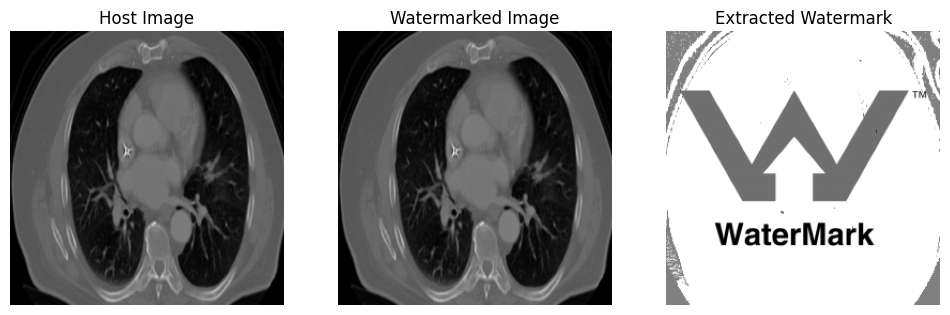

In [17]:
# ===============================
# Watermarking Inference Code with Metrics (Fixed)
# ===============================

import cv2
import numpy as np
import pywt
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# -------------------------------
# Load AlphaNet model
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # adaptive alpha between 0.002 and 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlphaNet().to(device)
model.load_state_dict(torch.load("/content/alpha_net.pth", map_location=device))
model.eval()

# -------------------------------
# Utility functions
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32) / 255.0

def embed_watermark(host, watermark, alpha):
    coeffs = pywt.dwt2(host, 'haar')
    LL, (LH, HL, HH) = coeffs

    wm = cv2.resize(watermark, LH.shape[::-1])
    LH_emb = LH + alpha * wm
    HL_emb = HL + alpha * wm

    wm_img = pywt.idwt2((LL, (LH_emb, HL_emb, HH)), 'haar')
    return np.clip(wm_img, 0, 1)

def extract_watermark(wm_img, host, alpha):
    c1 = pywt.dwt2(host, 'haar')
    c2 = pywt.dwt2(wm_img, 'haar')

    LH1, HL1 = c1[1][0], c1[1][1]
    LH2, HL2 = c2[1][0], c2[1][1]

    wm = ((LH2 - LH1) + (HL2 - HL1)) / (2 * alpha)
    return np.clip(wm, 0, 1)

def normalized_correlation(w1, w2):
    w1_flat = w1.flatten()
    w2_flat = w2.flatten()
    nc = np.sum(w1_flat * w2_flat) / (np.sqrt(np.sum(w1_flat**2) * np.sum(w2_flat**2)) + 1e-8)
    return nc

# -------------------------------
# User Input: host image & watermark
# -------------------------------
host_path = "/content/data/host/000016 (3).png"        # change to your host image path
wm_path = "/content/data/watermark/watermark.png"     # change to your watermark image path

host = load_gray(host_path)
wm = load_gray(wm_path, size=host.shape[0])

# -------------------------------
# Predict adaptive alpha
# -------------------------------
host_t = torch.tensor(host).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    alpha = model(host_t)[0,0].cpu().numpy()
print("Predicted alpha:", alpha)

# -------------------------------
# Embed watermark
# -------------------------------
wm_img = embed_watermark(host, wm, alpha)

# -------------------------------
# Extract watermark
# -------------------------------
wm_ext = extract_watermark(wm_img, host, alpha)

# Resize original watermark to match extracted watermark for NC calculation
wm_resized = cv2.resize(wm, (wm_ext.shape[1], wm_ext.shape[0]))

# -------------------------------
# Compute metrics
# -------------------------------
psnr_val = psnr(host, wm_img)
ssim_val = ssim(host, wm_img, data_range=1.0)
nc_val = normalized_correlation(wm_resized, wm_ext)

print(f"PSNR (Host vs Watermarked): {psnr_val:.2f}")
print(f"SSIM (Host vs Watermarked): {ssim_val:.4f}")
print(f"NC (Watermark vs Extracted): {nc_val:.4f}")

# -------------------------------
# Display results
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Host Image")
plt.imshow(host, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(wm_img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(wm_ext, cmap='gray')
plt.axis('off')

plt.show()
